In [4]:
import pymongo as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [5]:
client = pm.MongoClient()
db = client["Fields"]

# 臺灣指數公司特選臺灣上市上櫃多因子優選成長30指數編製規則

### 採樣母體
    1. 市值前300大
### 流動性篩選標準
    1. 12個月成交金額前20%
    2. 至少8個月自由流通週轉率>3%
### 指標篩選
    1. 近四季營業利益總和前75%
    2.  a.金融業: 近四季資產報酬率前75%
        b.非金融業: 近四季股東權益報酬率前75%
    3. 下行風險: 負日報酬來算標準差*sqrt252，取倒數前75% - 意即下方波動最大25%不要
### 排序方式 (重點)
    1. 市值佔比最大且佔比>10%者入選
    2. 企業價值成長指標*前50%高者，依252日標準差倒數排序(再一次選低波動優先)   *: EBIDTA/(發行市值+特別股股本+總負債-現金及約當現金)


##### 取得資料

In [51]:
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime.today()
# 日資料
還原收盤價 = pd.DataFrame(db["還原收盤價"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
市值 = pd.DataFrame(db["總市值(億)"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
成交金額 = pd.DataFrame(db["成交金額(千)"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
成交量 = pd.DataFrame(db["成交量"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
股本 = pd.DataFrame(db["股本(百萬)"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期") * 1000
# 月資料
全體及關係人持股 = pd.DataFrame(db["全體及其關係人持股張數_M"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期").resample("M").last()
# 季資料
庫藏股 = pd.DataFrame(db["庫藏股票(千)_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
營業收入 = pd.DataFrame(db["營業收入淨額_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
資產報酬率 = pd.DataFrame(db["稅後資產報酬率(%)_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
權益報酬率 = pd.DataFrame(db["稅後權益報酬率(%)_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
EBITDA = pd.DataFrame(db["EBITDA_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
特別股股本 = pd.DataFrame(db["特別股股本_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
負債 = pd.DataFrame(db["負債總計_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
現金及約當現金 = pd.DataFrame(db["現金及約當現金_Q"].find({"日期": {"$gte": start, "$lte": end}}, {"_id": 0})).set_index("日期")
# 其他資料
產業名稱 = pd.DataFrame(client["Index"]["產業名稱"].find({}, {"_id": 0}))

##### 計算所需使用數值

In [222]:
def free_securities(股本, 全體及關係人股, 庫藏股, 成交量, 還原收盤價):
    全 = 全體及關係人股.align(股本, join="right", method="ffill")[0]
    庫 = 庫藏股.align(股本, join="right", method="ffill")[0]
    成 = 成交量.resample("M").sum().align(股本, join="right", method="ffill")[0]
    自由流通股數 = 股本 - (全+庫)
    自由流通加權 = (自由流通股數*還原收盤價)
    自由流通加權比率 = 自由流通加權.divide(自由流通加權.sum(axis=1), axis=0)
    自由流通量週轉率 = 成 / 自由流通股數
    自由流通量系數 = 自由流通股數 / 股本
    自由流通量系數 = np.clip(自由流通量系數, 1, 0.01)
    return 自由流通量系數, 自由流通週轉率, 自由流通加權比率
    
    
自由流通量系數, 自由流通週轉率, 自由流通加權比率 = free_securities(股本, 全體及關係人持股, 庫藏股, 成交量, 還原收盤價)
報酬率 = (np.log(還原收盤價) - np.log(還原收盤價.shift(1))).replace([np.nan, -np.inf, np.inf], 0)
下行風險 = 報酬率[報酬率<0].fillna(0).rolling(252).sum()/126*np.sqrt(252)
營業收入總和 = 營業收入.rolling(4).sum().align(還原收盤價, join="right", method="ffill")[0]
市值比重 = 市值.divide(市值.sum(axis=1), axis=0)
標準差 = 報酬率.rolling(252).std()

c:\Users\ChastLai\Documents\Python Scripts\Chast\env_ml\.venv\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


##### 沿規則順序篩選股票

In [160]:
# 市值挑前300大
c1 = 市值.rank(axis=1, ascending=False) <= 300
金額 = 成交金額.rolling(252).sum()
c2 = 金額.gt(金額.quantile(.8, axis=1), axis=0)
c3 = 自由流通週轉率 > 0.03
c4 = 營業收入總和.gt(營業收入總和.quantile(.25, axis=1), axis=0)
金融 = 產業名稱[產業名稱["產業名稱"] == "金融保險"]["股票代號"].astype(str).values
非金 = 產業名稱[產業名稱["產業名稱"] != "金融保險"]["股票代號"].astype(str).values
資產報酬D = 資產報酬率.align(還原收盤價, join="right", method="ffill")[0]
權益報酬D = 權益報酬率.align(還原收盤價, join="right", method="ffill")[0]
c5_1 = 資產報酬D.loc[:, 金融].rolling(4).sum().gt(資產報酬D.loc[:, 金融].rolling(4).sum().quantile(.25, axis=1), axis=0)
c5_2 = 權益報酬D.loc[:, 非金].rolling(4).sum().gt(權益報酬D.loc[:, 非金].rolling(4).sum().quantile(.25, axis=1), axis=0)
c5 = pd.concat([c5_1, c5_2], axis=1)
c6 = 下行風險.lt(下行風險.quantile(.75, axis=1), axis=0)

In [161]:
def recol(*params):
    param = list(params)
    for i in range(len(params)):
        param[i] = param[i].reindex(sorted(param[i].columns), axis=1)
    
    return param
c1, c2, c3, c4, c5, c6 = recol(c1, c2, c3, c4, c5, c6)
filter = (c1&(c2|c3)&c4&c5&c6)

##### 根據篩選的股票，用兩個規則排序


In [162]:
EBITDAD = (EBITDA.rolling(4).sum()*1000).align(還原收盤價, join="right", method="ffill")[0]
特別股股本D = 特別股股本.align(還原收盤價, join="right", method="ffill")[0]
總負債D = 負債.align(還原收盤價, join="right", method="ffill")[0]
現金及約當現金D = 現金及約當現金.align(還原收盤價, join="right", method="ffill")[0]
發行市值 = 股本 * 還原收盤價
EBEV = EBITDAD / (發行市值 + 特別股股本D + 總負債D - 現金及約當現金D)

In [172]:

def 股票篩選清單(EBEV, filter):
    trading_dict = dict()

    
    filterM = filter.resample("M").last()
    EBEVM = EBEV.resample("M").last()
    idx = filterM.index
    市值比重M = 市值比重.resample("M").last()
    標準差M = 標準差.resample("M").last()

    for i in idx:
        trading_list = list()
        fil = list(filterM.loc[i][filterM.loc[i]].index)
        if 市值比重M.loc[i, fil].max() > 0.1:
            trading_list.append(市值比重M.loc[i, fil].idxmax())

            fil.remove(str(市值比重M.loc[i, fil].idxmax()))
            
        EBEV排序 = EBEVM.loc[i, fil].sort_values(ascending=False)
        fil = list(EBEV排序.index[:int(len(EBEV排序)*.5)])
        標準差排序 = 標準差M.loc[i, fil].sort_values(ascending=True)
        trading_list.extend(標準差排序.index[:30-len(trading_list)])
        trading_dict[i] = trading_list
    return trading_dict

交易清單 = 股票篩選清單(EBEV, filter)

In [200]:
交易清單整理 = pd.DataFrame({i: v for i, v in 交易清單.items() if len(v) != 0}).T.align(還原收盤價, join="right", method="ffill", axis=0)[0].shift(1)
    

In [245]:
報酬率隔日 = 報酬率.shift(-1)
rt = dict()
for i, v in 交易清單整理.dropna(how='all', axis=0).iterrows():
    流通比率 = 自由流通加權比率.loc[i, v.values]
    流通比率 = 流通比率 / 流通比率.sum()
    流通比率 = np.clip(流通比率, 0.3, 0.001)
    流通比率 = 流通比率.sort_values(ascending=False)
    if 流通比率.iloc[:5].sum() > 0.6:
        流通比率.iloc[:5] *= 0.6/流通比率.iloc[:5].sum()
        流通比率.iloc[5:] *= 0.4/流通比率.iloc[5:].sum()
    rt[i] = (報酬率隔日.loc[i, v.values] * 流通比率).values


C:\Users\ChastLai\AppData\Local\Temp\ipykernel_22276\1941389619.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  流通比率.iloc[5:] *= 0.4/流通比率.iloc[5:].sum()
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_22276\1941389619.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  流通比率.iloc[5:] *= 0.4/流通比率.iloc[5:].sum()
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_22276\1941389619.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  流通比率.iloc[5:] *= 0.4/流通比率.iloc[5:].sum()
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_22276\1941389619.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  流通比率.iloc[5:] *= 0.4/流通比率.iloc[5:].sum()
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_22276\1941389619.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  流通比率.iloc[5:] *= 0.4/流通比率.iloc[5:].sum()
C:\Users\ChastLai\AppData\Local\Temp\ipykernel_22276\1941389619.py:10: RuntimeWarning: divide by zero encountered in double_s

<AxesSubplot: >

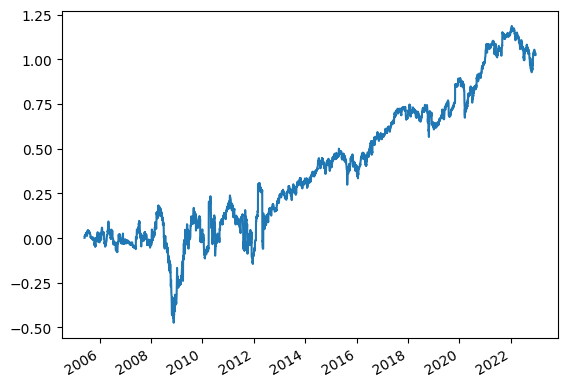

In [255]:
pd.DataFrame(rt).T.cumsum().dropna(how="all").sum(axis=1).plot()

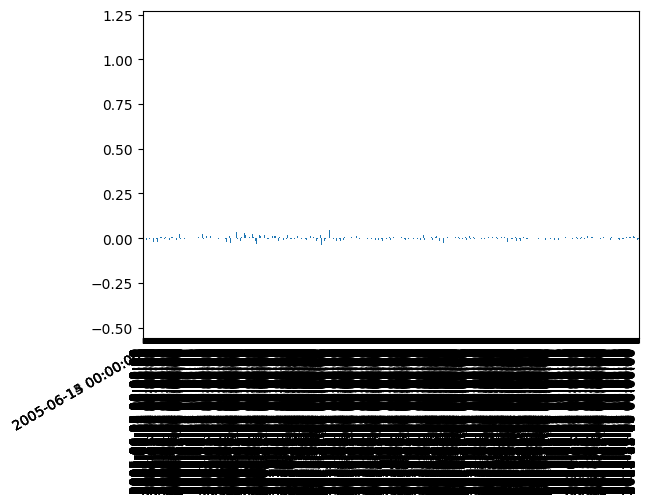

In [260]:
pd.DataFrame(rt).T.cumsum().dropna(how="all").sum(axis=1).plot()
pd.DataFrame(rt).T.dropna(how="all").sum(axis=1).plot.bar()
plt.show()

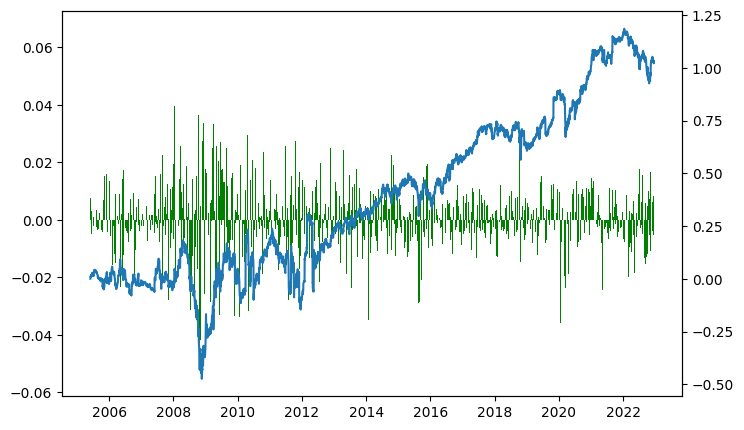

In [266]:
fig, ax = plt.subplots(figsize=(8, 5))
daily = pd.DataFrame(rt).T.dropna(how="all").sum(axis=1)
cum = pd.DataFrame(rt).T.cumsum().dropna(how="all").sum(axis=1)
ax1 = ax.twinx()
ax.bar(daily.index, height=daily.values, color="green", width=2)
ax1.plot(cum)

plt.show()

In [262]:
pd.DataFrame(rt).T.cumsum().dropna(how="all").sum(axis=1)

2005-06-01    0.001119
2005-06-02    0.008840
2005-06-03    0.012090
2005-06-06    0.008840
2005-06-07    0.011010
                ...   
2022-12-12    1.026566
2022-12-13    1.034676
2022-12-14    1.035577
2022-12-15    1.026828
2022-12-16    1.023167
Length: 4334, dtype: float64